In [2]:
import boto3
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

In [3]:
AWS_ACCESS_KEY = 'TODO: AWS_ACCESS_KEY'
AWS_SECRET_KEY = 'TODO: AWS_SECRET_KEY'
S3_BUCKET_NAME = 'raw-data-test-task-talpa'
FILE_NAME = 'sample.csv'

In [4]:
def describe_df(df: pd.DataFrame):
    print(f'Number of rows: {len(df)}')
    print(f'Number of columns: {len(df.columns)}')
    print(f'Column names: {str(df.columns.tolist())}')
    print(f'Column names: {str(df.dtypes.tolist())}')

    print('DataFrame information:')
    print(df.info())

    print('Summary statistics:')
    print(df.describe())

In [6]:
# Imagine we received the file into the data lake on S3
s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY)
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=FILE_NAME)
csv_string = csv_obj['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string))

In [8]:
print(df.head())

   order_id    source  customer_id  payment_id  voucher_id  product_id  \
0  20771583  services     10432878  23974630.0  20627711.0    109718.0   
1  27622273  services      7247832  31603820.0         NaN    120531.0   
2  33378861  services     13128212  37658983.0  32198021.0    118353.0   
3  10692997  services      1683201  12112832.0  10305426.0     82407.0   
4   8245381  services      1683201   8845022.0   7704279.0         NaN   

  website order_status    voucher_status payment_status  \
0    VVNL         PAID           EXPIRED           PAID   
1    VVNL         PAID               NaN           PAID   
2    VVNL         PAID           EXPIRED           PAID   
3    VVNL         PAID  PAID_TO_SUPPLIER           PAID   
4    VVNL         PAID              USED           PAID   

                order_date             payment_date  
0  2018-07-12 17:33:04.000  2018-07-13 08:12:33.000  
1  2019-10-25 23:47:04.000  2019-10-25 23:48:37.000  
2  2021-01-22 11:52:08.000  2021-01-22

In [9]:
describe_df(df)

Number of rows: 200
Number of columns: 12
Column names: ['order_id', 'source', 'customer_id', 'payment_id', 'voucher_id', 'product_id', 'website', 'order_status', 'voucher_status', 'payment_status', 'order_date', 'payment_date']
Column names: [dtype('int64'), dtype('O'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O')]
DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        200 non-null    int64  
 1   source          200 non-null    object 
 2   customer_id     200 non-null    int64  
 3   payment_id      189 non-null    float64
 4   voucher_id      151 non-null    float64
 5   product_id      165 non-null    float64
 6   website         200 non-null    object 
 7   order_status    200 non-null    object 
 8   vou

In [11]:
# Convert 'order_date' and 'payment_date' to datetime
df['order_datetime'] = pd.to_datetime(df['order_date'])
df['payment_datetime'] = pd.to_datetime(df['payment_date'])

# Extract date part from the datetime columns
df['order_date'] = df['order_datetime'].dt.date
df['payment_date'] = df['payment_datetime'].dt.date

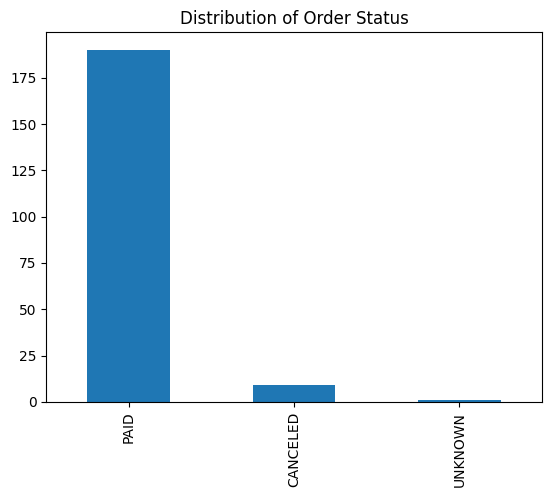

In [12]:
# Plot distributions
df['order_status'].value_counts().plot(kind='bar', title='Distribution of Order Status')
plt.show()

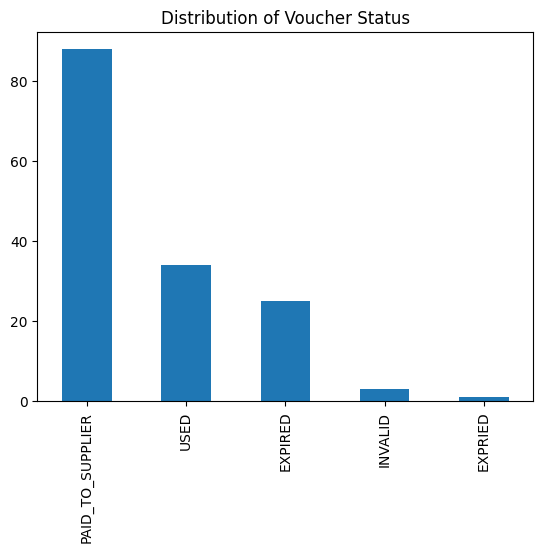

In [13]:
df['voucher_status'].value_counts().plot(kind='bar', title='Distribution of Voucher Status')
plt.show()

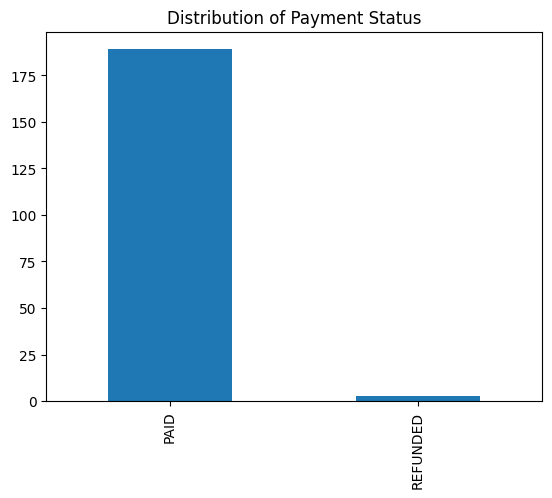

In [14]:
df['payment_status'].value_counts().plot(kind='bar', title='Distribution of Payment Status')
plt.show()

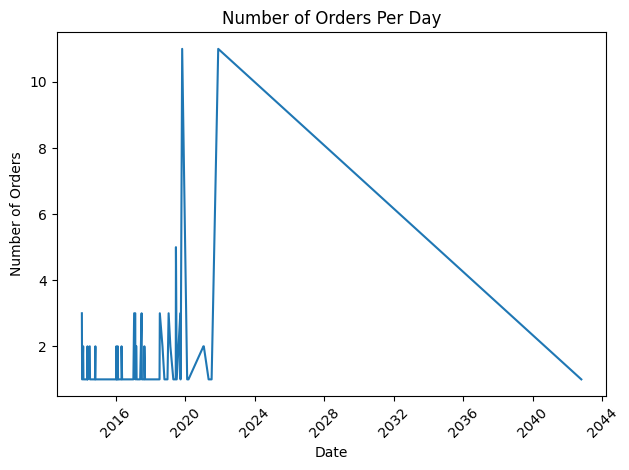

In [17]:
# Plot number of orders per day
# order with order_date of 10/17/2042 14:29 is an outlier, we should account for it during ETL
order_counts_per_day = df['order_date'].value_counts().sort_index()
order_counts_per_day.plot(kind='line', title='Number of Orders Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

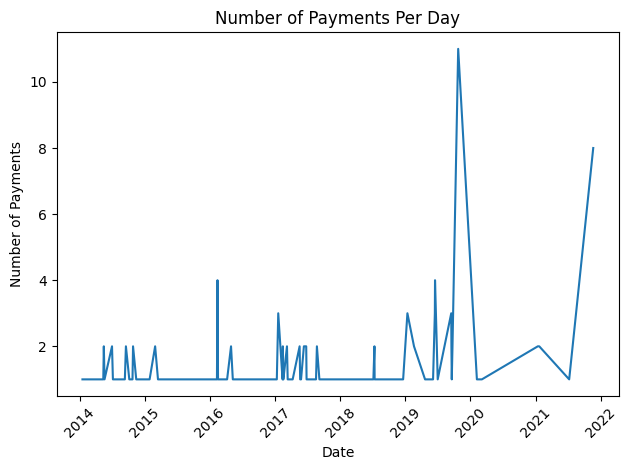

In [18]:
# Plot number of payments per day
payment_counts_per_day = df['payment_date'].value_counts().sort_index()
payment_counts_per_day.plot(kind='line', title='Number of Payments Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Payments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# check discrepancies, e.g. if all orders have an order date less than the payment date
discrepancies = df[df['order_datetime'] >= df['payment_datetime']]
if not discrepancies.empty:
    print(f"Found {len(discrepancies)} discrepancies where order date is not less than the payment date.")
    print(discrepancies[['order_id', 'order_datetime', 'payment_datetime']])

# this is the same one discrepancy we saw before

Found 1 discrepancies where order date is not less than the payment date.
     order_id      order_datetime    payment_datetime
193  22224396 2042-10-17 14:29:05 2018-10-20 15:39:40
